In [2]:
import os
os.chdir("/home/149/ab8992/tasman-tides")
# from recipes import surfacespeed
from importlib import reload
import ttidelib as tt
from ttidelib import logmsg
import shutil
import subprocess
import dask
import xarray as xr
from matplotlib import pyplot as plt
experiment,outputs = "full-20","output*"
from dask.distributed import Client, default_client
from pathlib import Path
try:
    # Try to get the existing Dask client
    client = default_client()
except ValueError:
    # If there's no existing client, create a new one
    client = Client()

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/34489/status,
Dashboard: /proxy/34489/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38509,Workers: 7
Dashboard: /proxy/34489/status,Total threads: 28
Started: 1 minute ago,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:35913,Total threads: 4
Dashboard: /proxy/40169/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:35687,


## Find non advective bottom cells

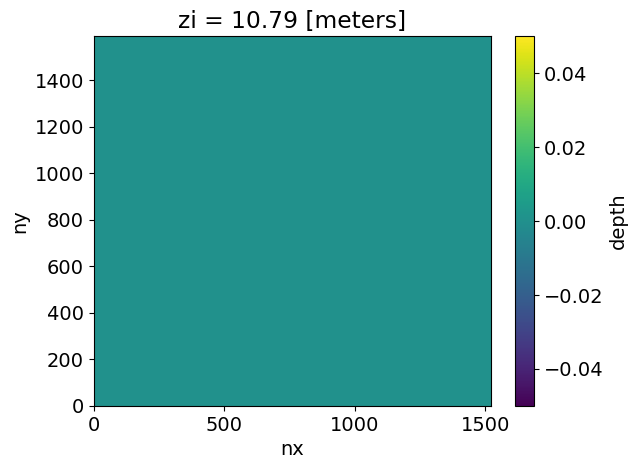

In [70]:
topo = xr.open_dataset("/g/data/nm03/ab8992/ttide-inputs/blank-40/topog.nc",chunks = "auto")
depth = topo.depth.load()
scored = np.sign(depth - depth.roll(nx=-1,roll_coords=False)) 
scored += np.sign(depth - depth.roll(nx=1,roll_coords=False))
scored += np.sign(depth - depth.roll(ny=-1,roll_coords=False))
scored += np.sign(depth - depth.roll(ny=1,roll_coords=False))

holes = scored.where(scored == -4,0) * - 0.25
holes[0,:] = 0
holes[-1,:] = 0
holes[:,0] = 0
holes[:,-1] = 0
holes.plot()

In [3]:
topo = xr.open_dataset("/g/data/nm03/ab8992/ttide-inputs/blank-40/topog_raw.nc",chunks = "auto")


0.3.0


<xarray.Dataset>
Dimensions:    (lat: 1590, lon: 1520)
Coordinates:
  * lon        (lon) float64 142.0 142.0 142.1 142.1 ... 179.9 179.9 180.0 180.0
  * lat        (lat) float64 -55.99 -55.97 -55.95 ... -26.05 -26.03 -26.01
Data variables:
    elevation  (lat, lon) float64 dask.array<chunksize=(1590, 1520), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

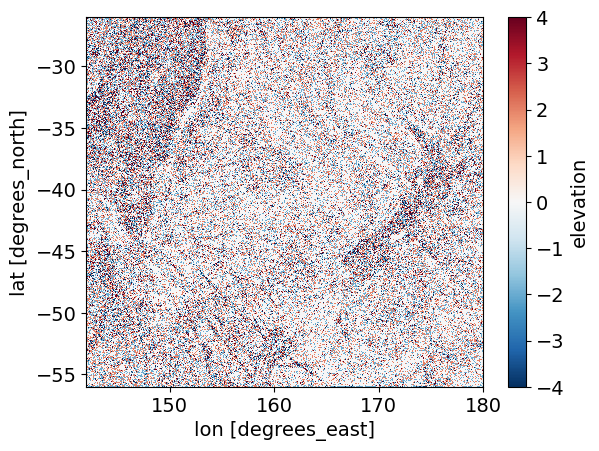

In [13]:
%matplotlib inline
plt.show()

## Plot all potholes:

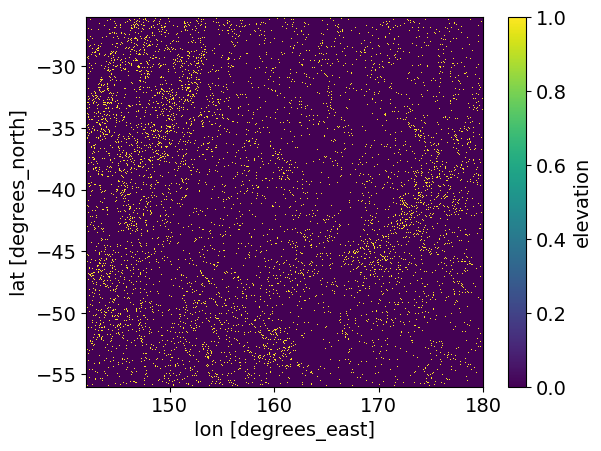

In [53]:
## use Find all the points in topo that are lower than all 4 neighbours
scored = np.sign(topo - topo.roll(lon=-1,roll_coords=False)) 
scored += np.sign(topo - topo.roll(lon=1,roll_coords=False))
scored += np.sign(topo - topo.roll(lat=-1,roll_coords=False))
scored += np.sign(topo - topo.roll(lat=1,roll_coords=False))

holes = scored.where(scored == -4,0) * - 0.25
holes[0,:] = 0
holes[-1,:] = 0
holes[:,0] = 0
holes[:,-1] = 0
holes.plot()

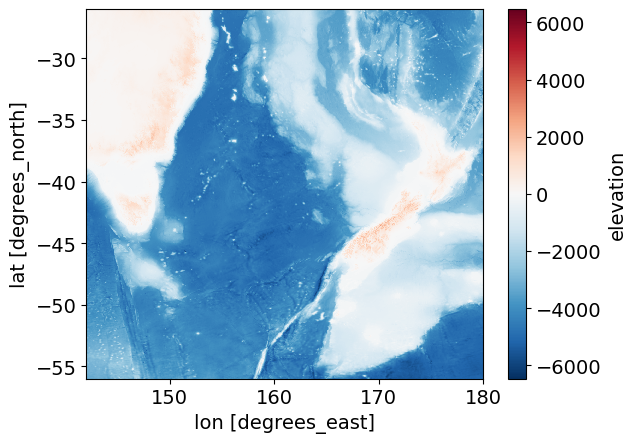

In [40]:
# topo = topo.elevation.load()
topo.plot()

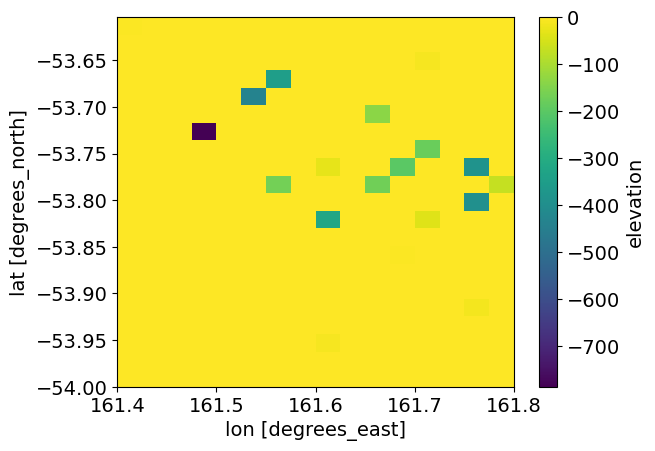

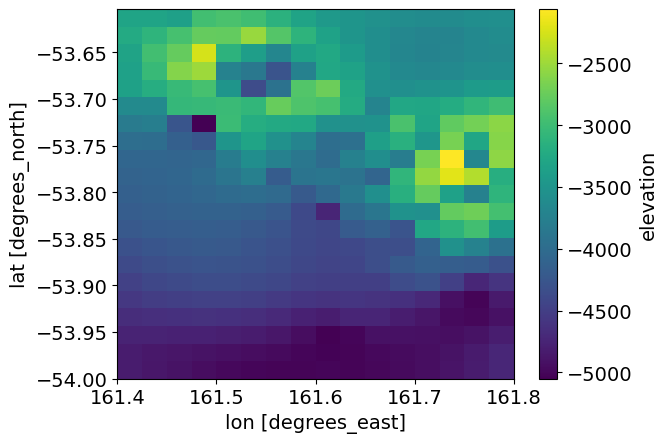

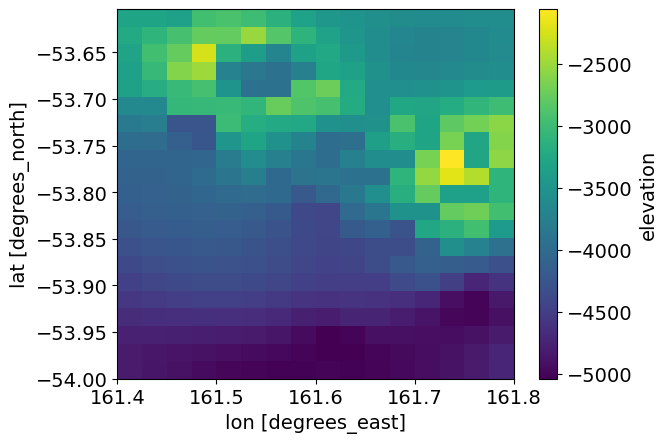

In [67]:
import xarray as xr
import numpy as np

# Assuming `topo` is your DataArray
zeros = xr.DataArray(np.zeros_like(topo), dims=topo.dims, coords=topo.coords)

arrays = [
    holes * (1 * topo - topo.roll(lon=-1, roll_coords=False)), ## These values are now negative
    holes * (1 * topo - topo.roll(lon=1, roll_coords=False)),
    holes * (1 * topo - topo.roll(lat=-1, roll_coords=False)),
    holes * (1 * topo - topo.roll(lat=1, roll_coords=False))
]

minmap = xr.concat(arrays, dim='new_dim').max('new_dim')

lon = slice(161.4,161.8)
lat = slice(-54,-53.6)
# lon = slice(None,None)
# lat = slice(None,None)

minmap.sel(lon = lon,lat = lat).plot()
plt.figure()
topo.sel(lon = lon,lat = lat).plot()
plt.figure()
filled_in = topo - minmap
filled_in.sel(lon = lon,lat = lat).plot()

In [74]:
filled_in

<xarray.DataArray 'elevation' (lat: 1590, lon: 1520)>
array([[-3369.92876772, -3364.94760546, -3351.2181782 , ...,
        -5118.34060994, -5116.92018845, -5111.76125323],
       [-3392.17527268, -3371.38733236, -3352.53567415, ...,
        -5133.11875179, -5134.57720949, -5122.8216203 ],
       [-3367.5725068 , -3337.08333388, -3300.84483607, ...,
        -5141.29577713, -5141.29577713, -5127.10869877],
       ...,
       [  103.        ,   104.        ,   105.        , ...,
        -2747.19149305, -2774.81369336, -2745.29332054],
       [  103.        ,   103.64622462,   105.        , ...,
        -2742.48771713, -2758.56454525, -2734.36496406],
       [  103.        ,   104.11792632,   104.88207368, ...,
        -2721.92341973, -2729.07466772, -2722.55162383]])
Coordinates:
  * lon      (lon) float64 142.0 142.0 142.1 142.1 ... 179.9 179.9 180.0 180.0
  * lat      (lat) float64 -55.99 -55.97 -55.95 -55.93 ... -26.05 -26.03 -26.01

In [73]:
filled_in.to_netcdf("/g/data/nm03/ab8992/ttide-inputs/blank-40/noholes_topog_raw.nc")

## Now use normal library to remake topog based on new topog_raw

In [87]:
os.chdir("/home/149/ab8992/cosima_regional/regional-mom6/")
import regional_mom6 as rm

ImportError: attempted relative import with no known parent package

In [82]:

yextent = [-56,-26]
xextent = [142,180]
expt_name = "nonoles-full-40"

# 
daterange = ["2015-01-01 00:00:00", "2015-12-31 00:00:00"]

## Place where all your input files go
inputdir = f"/g/data/nm03/ab8992/ttide-inputs/{expt_name}/"

## Directory where you'll run the experiment from
rundir = f"/home/149/ab8992/tasman-tides/rundirs/{expt_name}/"

## Directory where raw downloads go before processing
tmpdir = f"/scratch/v45/ab8992/reanalysis_tmp/ttide-20"
# tmpdir = f"/home/149/ab8992/tasman-tides/rundirs/full-20/inputdir/forcing"
# tmpdir = "/home/149/ab8992/tasman-tides/rundirs/mkic/archive/output000/"
## Directory where fre tools are stored
toolpath = "/home/157/ahg157/repos/mom5/src/tools/" ## Compiled tools needed for construction of mask tables
for i in [rundir,tmpdir,inputdir]:
    if not os.path.exists(i):
        subprocess.run(f"mkdir {i} -p",shell=True)
expt = rm.experiment(
    xextent,
    yextent,
    daterange,
    0.025,  ## Resolution
    100,      ## #zlayers
    20,       ## dz ratio
    5500,    ## Max depth of ocean
    rundir,
    inputdir,
    toolpath
)
expt.bathymetry(
    None,None,False,maketopog = False
)

ImportError: attempted relative import with no known parent package

## Draft save velocity recipe


In [91]:
home = Path("/home/149/ab8992/tasman-tides")
gdata = Path("/g/data/nm03/ab8992")

def save_filtered_vels(experiment,outputs):
    """
    Calculate the filtered velocities over 149 hours and save u'u', v'v', u'v' all averaged over 149 hours as separate files
    """
    m2 = 360 / 28.984104 ## Period of m2 in hours
    averaging_window = int(12 * m2) ## this comes out to be 149.0472 hours, so close enough to a multiple of tidal periods
    m2f = 1/ m2    ## Frequency of m2 in radians per hour

    outpath = gdata / "postprocessed" / experiment 
    if not os.path.exists(outpath):
        for i in ["UU","VV","UV"]:
            if not os.path.exists(outpath / i):
                os.makedirs(outpath / i)

    data = tt.collect_data(
        experiment,
        outputs=outputs,
        rawdata = ["u","v"],
        bathy=False,
        chunks = {"time": -1,"xb":-1,"zl":10}
        )
    for i in range(0,len(data.time) // averaging_window):
        u_ = data.u.isel(
                time = slice(i * averaging_window, (i + 1) * averaging_window)
                ).chunk({"time":-1}).drop(["lat","lon"])
        v_ = data.v.isel(
                time = slice(i * averaging_window, (i + 1) * averaging_window)
                ).chunk({"time":-1}).drop(["lat","lon"])
        U = tt.m2filter(
            u_,
            m2f)
        V = tt.m2filter(
            v_,
            m2f)
        
        mid_time = data.time[round(i + 0.5 * averaging_window) ] ## Middle of time window time
        UU = (U * U).mean("time").expand_dims("time").assign_coords(time = [mid_time])
        VV = (V * V).mean("time").expand_dims("time").assign_coords(time = [mid_time])
        UV = (U * V).mean("time").expand_dims("time").assign_coords(time = [mid_time])

        UU.to_netcdf(outpath / "UU" / f"UU_{str(i).zfill(3)}.nc")
        VV.to_netcdf(outpath / "VV"/ f"VV_{str(i).zfill(3)}.nc")
        UV.to_netcdf(outpath / "UV"/ f"UV_{str(i).zfill(3)}.nc")


    return 

save_filtered_vels("full-20","output008")

[2881. 2882. 2883. 2884. 2885. 2886. 2887. 2888. 2889. 2890. 2891. 2892.
 2893. 2894. 2895. 2896. 2897. 2898. 2899. 2900. 2901. 2902. 2903. 2904.
 2905. 2906. 2907. 2908. 2909. 2910. 2911. 2912. 2913. 2914. 2915. 2916.
 2917. 2918. 2919. 2920. 2921. 2922. 2923. 2924. 2925. 2926. 2927. 2928.
 2929. 2930. 2931. 2932. 2933. 2934. 2935. 2936. 2937. 2938. 2939. 2940.
 2941. 2942. 2943. 2944. 2945. 2946. 2947. 2948. 2949. 2950. 2951. 2952.
 2953. 2954. 2955. 2956. 2957. 2958. 2959. 2960. 2961. 2962. 2963. 2964.
 2965. 2966. 2967. 2968. 2969. 2970. 2971. 2972. 2973. 2974. 2975. 2976.
 2977. 2978. 2979. 2980. 2981. 2982. 2983. 2984. 2985. 2986. 2987. 2988.
 2989. 2990. 2991. 2992. 2993. 2994. 2995. 2996. 2997. 2998. 2999. 3000.
 3001. 3002. 3003. 3004. 3005. 3006. 3007. 3008. 3009. 3010. 3011. 3012.
 3013. 3014. 3015. 3016. 3017. 3018. 3019. 3020. 3021. 3022. 3023. 3024.
 3025. 3026. 3027. 3028. 3029.]


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


[3030. 3031. 3032. 3033. 3034. 3035. 3036. 3037. 3038. 3039. 3040. 3041.
 3042. 3043. 3044. 3045. 3046. 3047. 3048. 3049. 3050. 3051. 3052. 3053.
 3054. 3055. 3056. 3057. 3058. 3059. 3060. 3061. 3062. 3063. 3064. 3065.
 3066. 3067. 3068. 3069. 3070. 3071. 3072. 3073. 3074. 3075. 3076. 3077.
 3078. 3079. 3080. 3081. 3082. 3083. 3084. 3085. 3086. 3087. 3088. 3089.
 3090. 3091. 3092. 3093. 3094. 3095. 3096. 3097. 3098. 3099. 3100. 3101.
 3102. 3103. 3104. 3105. 3106. 3107. 3108. 3109. 3110. 3111. 3112. 3113.
 3114. 3115. 3116. 3117. 3118. 3119. 3120. 3121. 3122. 3123. 3124. 3125.
 3126. 3127. 3128. 3129. 3130. 3131. 3132. 3133. 3134. 3135. 3136. 3137.
 3138. 3139. 3140. 3141. 3142. 3143. 3144. 3145. 3146. 3147. 3148. 3149.
 3150. 3151. 3152. 3153. 3154. 3155. 3156. 3157. 3158. 3159. 3160. 3161.
 3162. 3163. 3164. 3165. 3166. 3167. 3168. 3169. 3170. 3171. 3172. 3173.
 3174. 3175. 3176. 3177. 3178.]


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


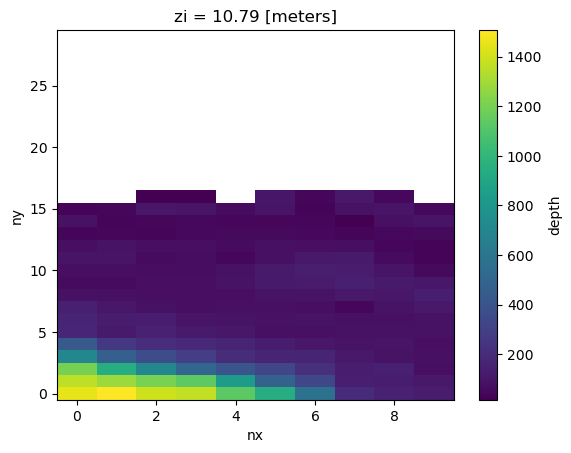

In [13]:
## Fix up topog
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
topog = xr.open_dataset("/home/149/ab8992/tasman-tides/rundirs/excavated-blank-20/inputdir/topog.nc")

topog.depth[0,466:468,0] = topog.depth[0,469,0]

topog.depth[0,450:480,0:10].plot()

topog.to_netcdf("/home/149/ab8992/tasman-tides/rundirs/excavated-blank-20/inputdir/topog_excavated.nc")


In [21]:
from pathlib import Path
base = Path("/home/149/ab8992/tasman-tides/rundirs/full-40")

outputs = (base / "archive").glob("output*")
temp = 0
for i in outputs:
    s = int(i.name.split("output")[-1])
    if s > temp:
        temp = s

outputs = [f"output{temp:03d}"]
outputs
    

['output039']

In [22]:
to_process = "20-24"

outputs = [f"output{int(i):03d}" for i in range(int(to_process.split("-")[0]),int(to_process.split("-")[1]) + 1)]
print(f"Processing outputs ({outputs})")

Processing outputs (['output020', 'output021', 'output022', 'output023', 'output024'])


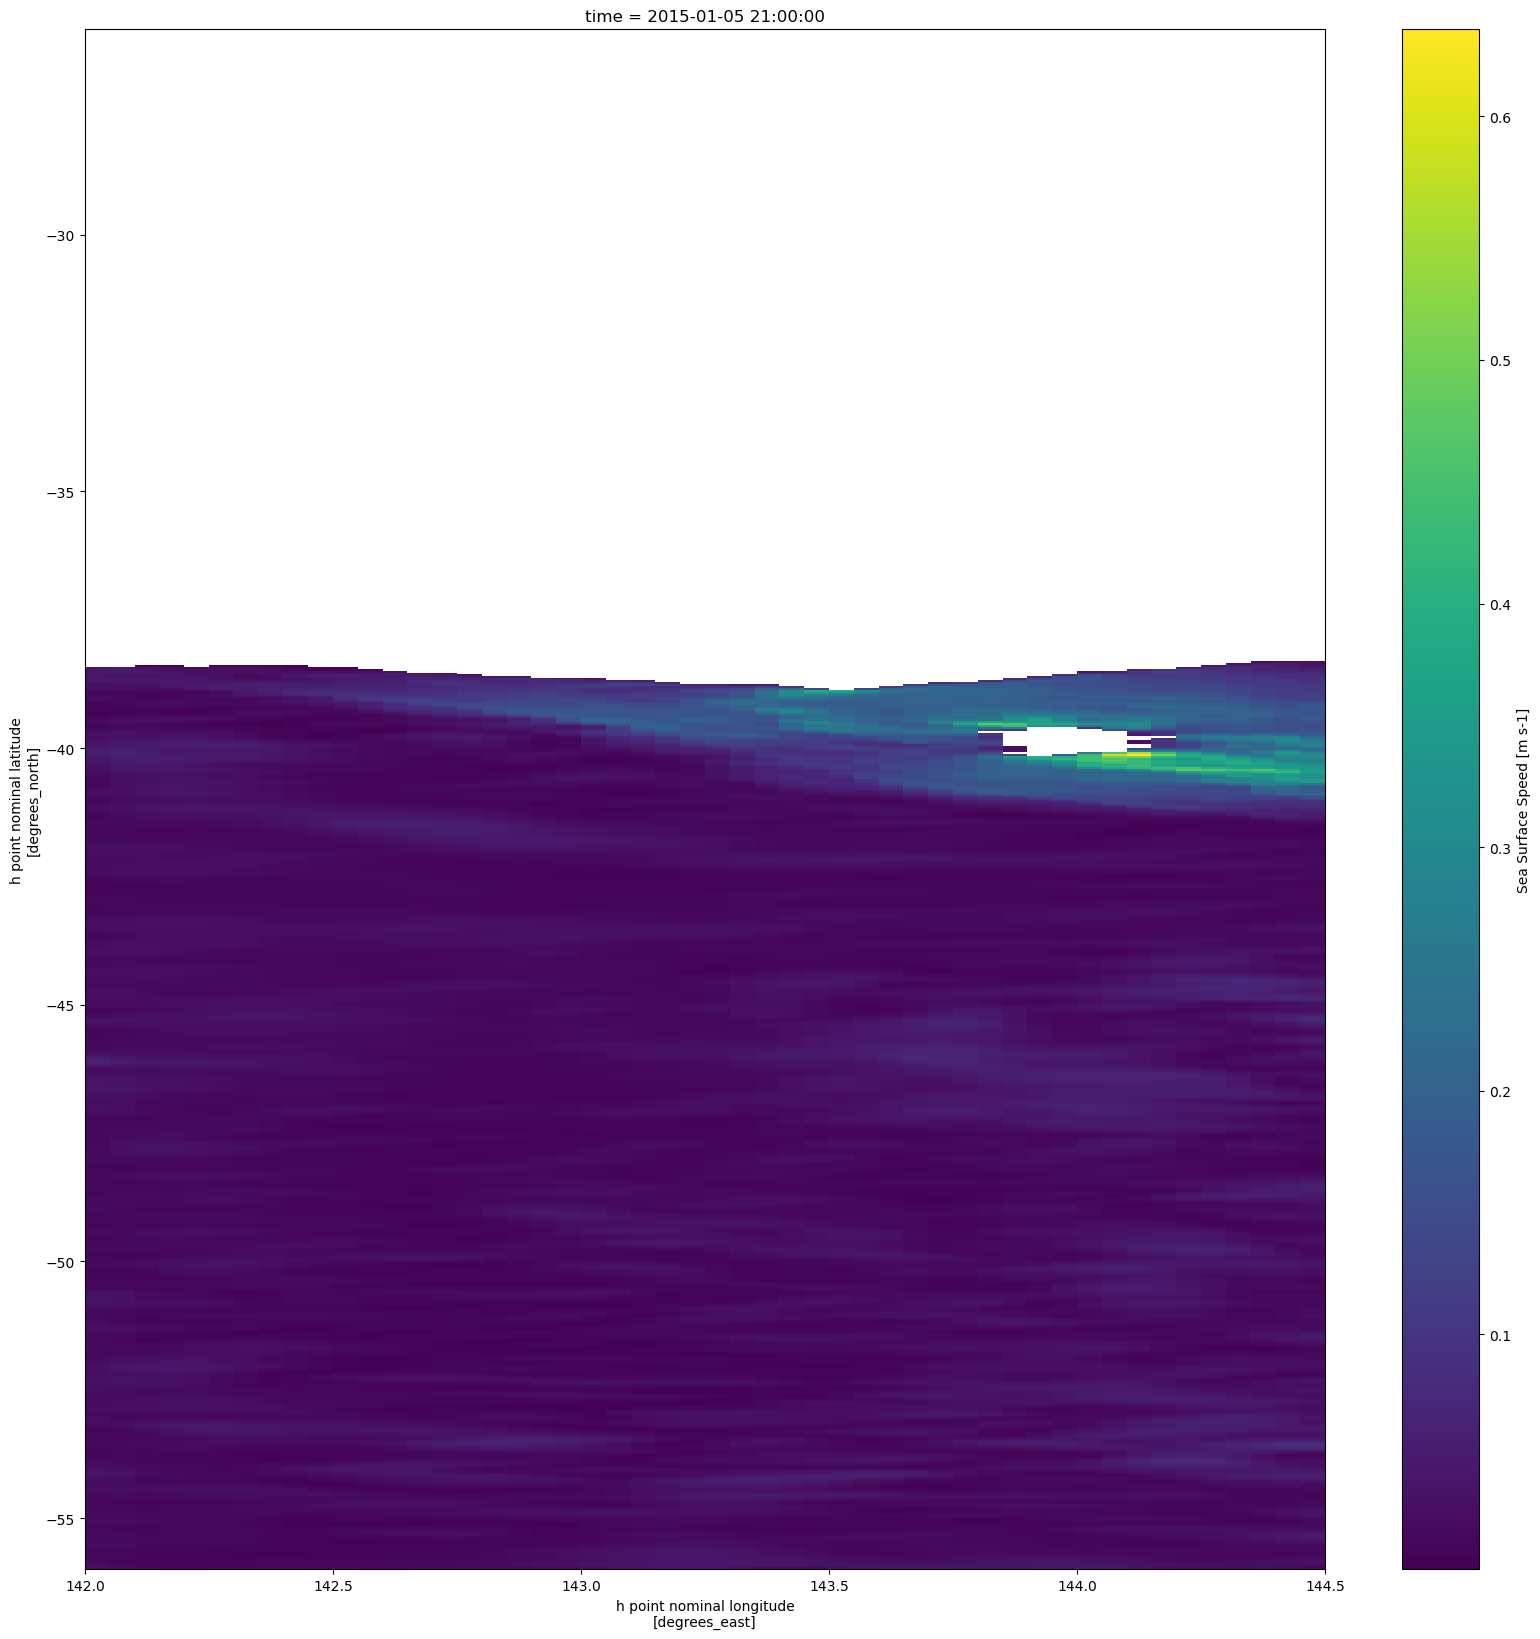

In [28]:
excavated = xr.open_dataset("/home/149/ab8992/tasman-tides/rundirs/excavated-alltides-blank-20/archive/output000/20150101.surface.nc")
%matplotlib inline
fig,ax = plt.subplots(1,figsize = (20,20))
excavated.speed.isel(time = -1,xh = slice(0,50)).plot(ax = ax)

In [4]:
from pathlib import Path
import numpy as np
import os
import shutil
import xarray as xr
from dask.distributed import Client
import haversine
from pathlib import Path
import sys
sys.path.append("/home/149/ab8992/tasman-tides/")
import ttidelib as tt
import json
import argparse

#TODO Allow python file to take arguments for chunking?



# parser = argparse.ArgumentParser()
# parser.add_argument('-p', '--to_process', type=str, help='outputs to process. If 0, runs all, if -1 runs only last',default = "last")
# parser.add_argument('-c', '--yb-chunksize', type=str, help='size of chunks across beam',default=12)
# args = parser.parse_args()

# to_process = args.to_process
# yb_chunksize = int(args.yb_chunksize)
to_process = "last"
yb_chunksize = 6

hourly_diags = {
    "rho":
    {"x":"xh","y":"yh","z":"z_l"},
    "khh":
    {"x":"xh","y":"yh","z":"z_l"},
    "e":
    {"x":"xh","y":"yh","z":"rho2_i"}
}

daily_diags = [
    "KE_stress"
    "KE_visc"
    "KE_horvisc"
    "PE_to_KE"
    "dKE_dt"
]

def save_chunked(data,name,chunks = yb_chunksize):
    if not (gdataout / f"{name}").exists():
        (gdataout / f"{name}").mkdir(parents=True)
    i = 0
    while i * chunks < data["yb"].shape[0]:
        data.isel(
            {
                "yb" : slice(i*chunks,(i+1)*chunks)
                }
                ).to_netcdf(gdataout / f"{name}" / f"{name}_y{i:02d}.nc")
        i += 1


# if __name__ == "__main__":
client = Client(threads_per_worker = 2)
print(client)
rundir = Path.cwd()
rundir = Path("/home/149/ab8992/tasman-tides/rundirs/full-20")
# Get the name of folder from Path object
expt = rundir.name
print(f"Running postprocessing for experiment {expt}")

if to_process == "last":
    # Find most recent output folder
    i = 0
    while (rundir / f"archive/output{i:03d}").exists():
        i += 1
    i -=1
    outputs = [f"output{i:03d}"]
    print(f"Processing last output ({outputs[0]})")


elif to_process == "all":
    print("Processing all outputs...")
    # Find all output folders
    i = 0
    outputs = []
    while (rundir / f"archive/output{i:03d}").exists():
        outputs.append(f"output{i:03d}")
        i += 1

    print(outputs)
else:
    outputs = [f"output{int(to_process):03d}"]

for output in outputs:
    print(f"\t\t Processing {output}")
    # Set up the run and output directories
    mom6out = rundir /  f"archive/{output}"
    print(f"Processing {mom6out}")
    gdataout = Path("/g/data/nm03/ab8992/outputs") / expt / f"{output}"
    if not gdataout.exists():
        gdataout.mkdir(parents=True)

    ## Simply move the surface variables to gdata. These are unchunked and for the entire domain

    try:
        surface_filename = list(mom6out.glob('*.surface.nc'))[0].name
        shutil.copy(str(mom6out / surface_filename),str(gdataout / "surface.nc"))
    except Exception as e:
        print("Couldn't move surface.nc")
        print(e)

    # Now we do the biggest ones, the hourly diagnostics. These are output in their own folder, chunked along y dimension
    # First do the velocities together, as these need to be summed along and against the beam

    theta = np.arctan((-43.3 + 49.8) / -17) # This is the angle of rotation
    u = xr.open_mfdataset(
        str(mom6out / f"*u.nc"),
        chunks={"z_l": 10,"time":10,"xq":-1,"yh":-1},
        decode_times=False,
    ).u.sel(xq = slice(144,170),yh = slice(-55,-40))
    v = xr.open_mfdataset(
        str(mom6out / f"*v.nc"),
        chunks={"z_l": 10,"time":10,"xh":-1,"yq":-1},
        decode_times=False,
    ).v.sel(xh = slice(144,170),yq = slice(-55,-40))

    u = tt.beamgrid(u,xname = "xq",chunks = yb_chunksize).persist()
    v = tt.beamgrid(v,yname = "yq",chunks = yb_chunksize).persist()

    # Rotate the velocities
    u_rot = u * np.cos(theta) - v * np.sin(theta)
    v_rot = u * np.sin(theta) + v * np.cos(theta)

    # Set the name of u to "u" and description to "velocity along beam"
    u_rot.name = "u"
    u_rot.attrs["long_name"] = "Velocity along beam (Eastward positive)"
    v_rot.name = "v"
    v_rot.attrs["long_name"] = "Velocity across beam (Northward positive)"

    save_chunked(u_rot,"u",chunks = yb_chunksize)
    save_chunked(v_rot,"v",chunks = yb_chunksize)

    del u
    del v
    del u_rot
    del v_rot
    ## Now do the rest of the hourly diagnostics
    for diag in hourly_diags:
        print(f"processing {diag}")
        try:
            ds = xr.open_mfdataset(
                str(mom6out / f"*{diag}.nc"),
                chunks={hourly_diags[diag]["z"]: 10,"time":10,"xh":-1,"yh":-1},
                decode_times=False,
            )[diag].sel({hourly_diags[diag]["x"] : slice(144,170), hourly_diags[diag]["y"] : slice(-55,-40)})
        except Exception as e:
            print(f"Failed to open {diag}")
            print(e)
            pass

        out = tt.beamgrid(ds,xname = hourly_diags[diag]["x"],yname = hourly_diags[diag]["y"]).persist()

        save_chunked(out,diag,chunks = yb_chunksize)
        del out

    ## Now do 2D surface diagnostics
    print(f"processing surface diagnostics over transect")
    try:
        ds = xr.open_mfdataset(
            str(mom6out / f"*surface.nc"),
            chunks={"time":10},
            decode_times=False,
        ).sel({
            "xh" : slice(144,170), "yh" : slice(-55,-40),
            "xq" : slice(144,170), "yq" : slice(-55,-40),
            })
    except Exception as e:
        print(f"Failed to open surface!")
        print(e)
        continue
    eta = tt.beamgrid(ds.zos)
    speed = tt.beamgrid(ds.speed)
    taux = tt.beamgrid(ds.taux,xname = "xq")
    tauy = tt.beamgrid(ds.tauy,yname = "yq")

    surface_transect = xr.merge([eta,speed,taux,tauy])
    surface_transect.to_netcdf(gdataout / "surface_transect.nc")
    del eta
    del speed
    del taux
    del tauy
    del surface_transect

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44993 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:33995' processes=1 threads=2, memory=4.00 GiB>
Running postprocessing for experiment full-20
Processing last output (output014)
		 Processing output014
Processing /home/149/ab8992/tasman-tides/rundirs/full-20/archive/output014
0.3.0


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "z_l" starting at index 10. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xesmf/frontend.py:696: UserWarning: Using dimensions ('yh', 'xq') from data variable u as the horizontal dimensions for the regridding.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xesmf/frontend.py:696: UserWarning: Using dimensions ('yq', 'xh') from data variable v as the horizontal dimensions for the regridding.
  warnings.warn(
